# **Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

plt.style.use('ggplot')
color_pal = sns.color_palette()

plt.rcParams['figure.figsize'] = 15, 5

# **Data**

In [4]:
df = pd.read_csv("monthly_milk_production.csv", index_col = "Date", parse_dates = True)
df.sort_index(inplace = True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


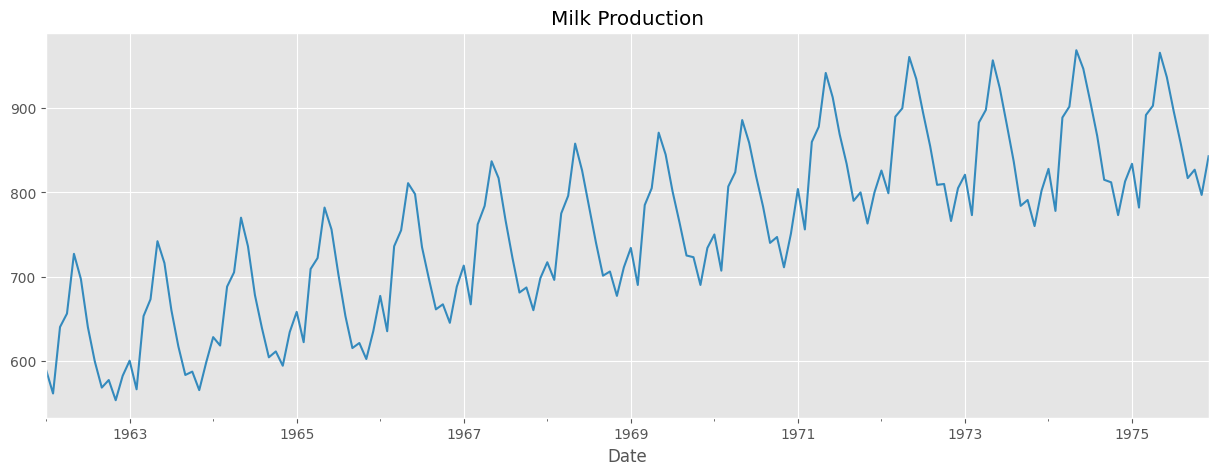

In [6]:
df.plot(title = "Milk Production",
        color = color_pal[1],
        legend = False)

plt.show()

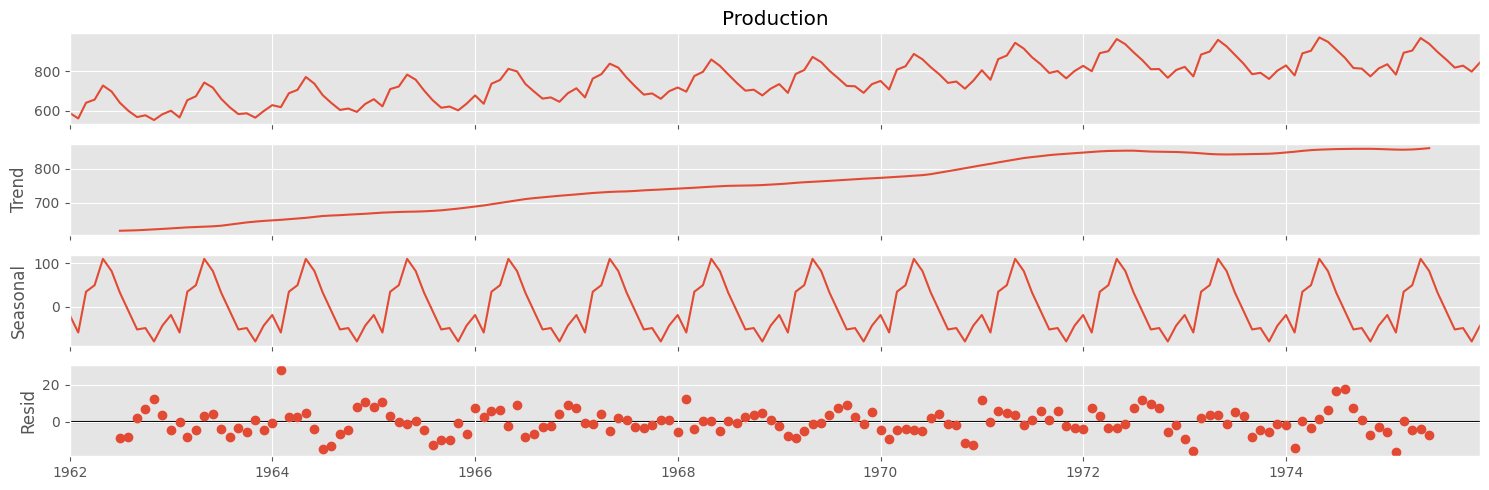

In [7]:
res = seasonal_decompose(df["Production"])
res.plot()
plt.show()

In [8]:
df["Year"] = df.index.year
df["Month"] = df.index.month
df.head()

,Production,Year,Month
Date,,,
1962-01-01,589,1962,1
1962-02-01,561,1962,2
1962-03-01,640,1962,3
1962-04-01,656,1962,4
1962-05-01,727,1962,5


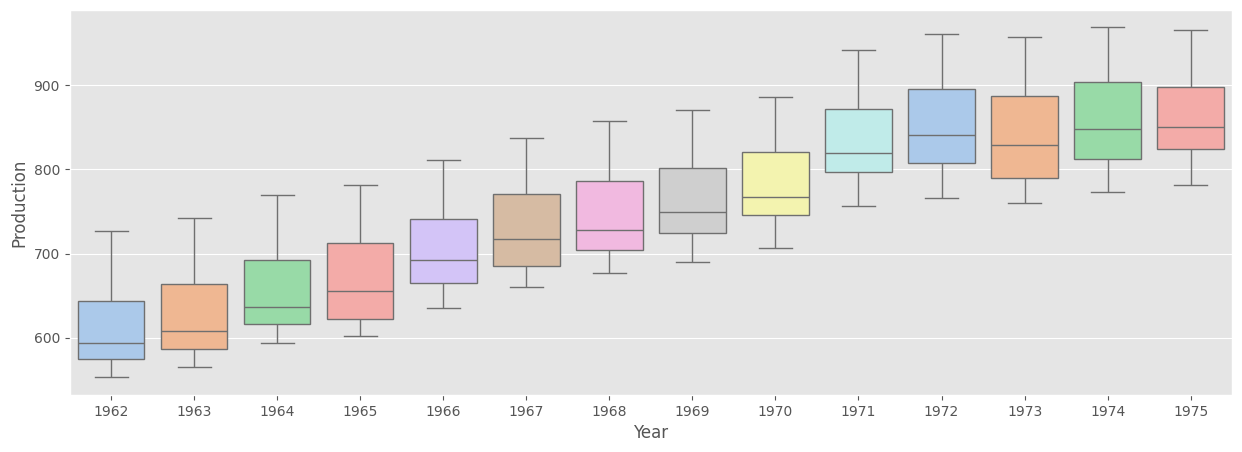

In [9]:
sns.boxplot(data = df, x = "Year", y = "Production", palette = "pastel", hue = "Year", legend = False)
plt.show()

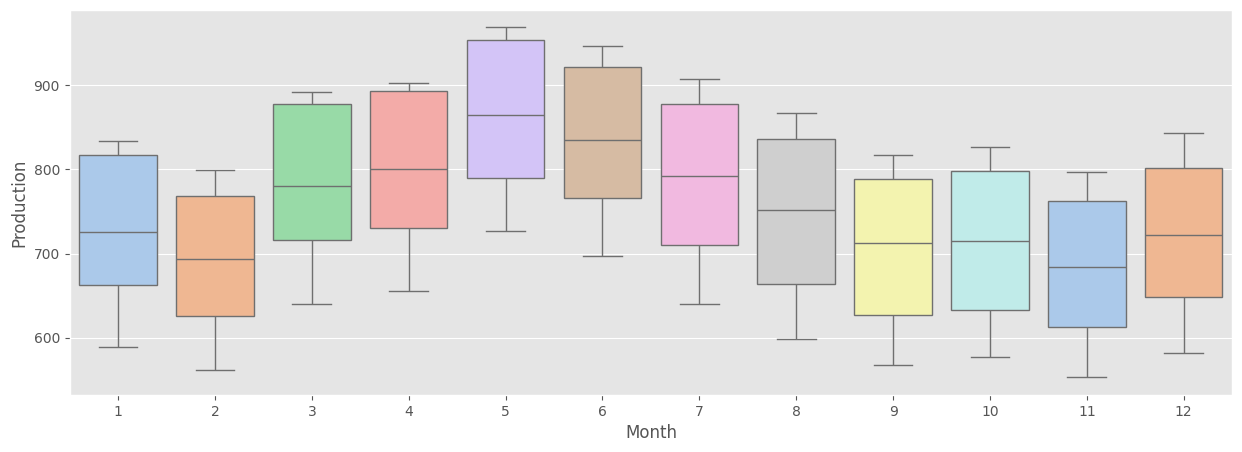

In [10]:
sns.boxplot(data = df, x = "Month", y = "Production", palette = "pastel", hue = "Month", legend = False)
plt.show()

# **XGBoost**

## Train & Test

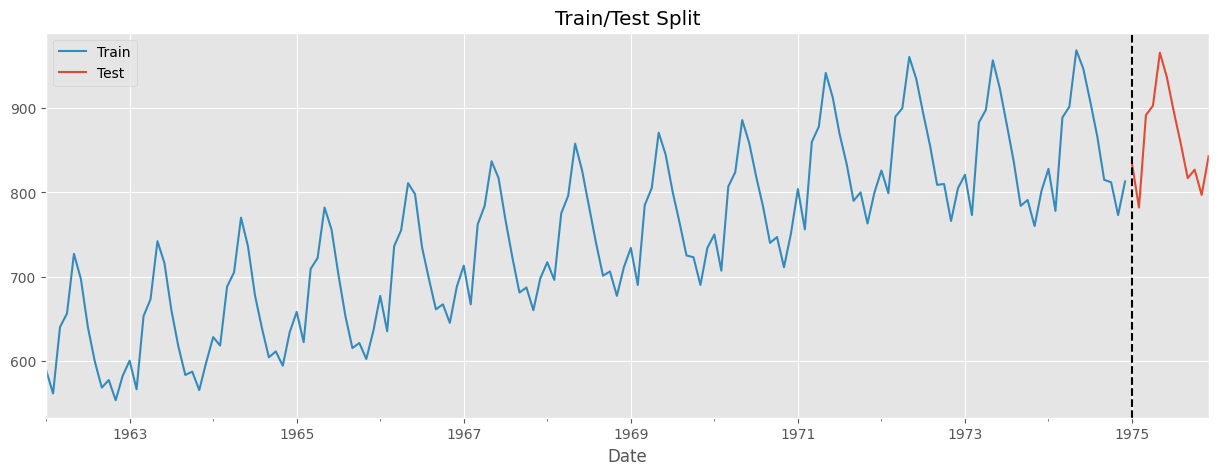

In [11]:
train = df.iloc[:156]
test = df.iloc[156:]

fig, ax = plt.subplots()

train["Production"].plot(ax = ax , label = "Training Set", color = color_pal[1])
test["Production"].plot(ax = ax, label = "Test Set", color = color_pal[0])

ax.axvline("1975-01-01", color = "black", ls = "--")
plt.title("Train/Test Split") 
plt.legend(["Train", "Test"])

plt.show()

In [12]:
df.columns

Index(['Production', 'Year', 'Month'], dtype='object')

In [13]:
Features = ["Year", "Month"]
Target = "Production"

X_train = train[Features]
y_train = train[Target]

X_test = test[Features]
y_test = test[Target]

## Model

In [14]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_round = 50,
                        learning_rate = 0.1)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:91.29437	validation_1-rmse:117.71247


[100]	validation_0-rmse:1.18155	validation_1-rmse:13.20779
[200]	validation_0-rmse:0.38288	validation_1-rmse:13.22804
[300]	validation_0-rmse:0.11934	validation_1-rmse:13.22927
[400]	validation_0-rmse:0.04176	validation_1-rmse:13.23423


c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:0.01231	validation_1-rmse:13.23194
[600]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[700]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[800]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[900]	validation_0-rmse:0.01169	validation_1-rmse:13.23199
[999]	validation_0-rmse:0.01169	validation_1-rmse:13.23199


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Feature Importance

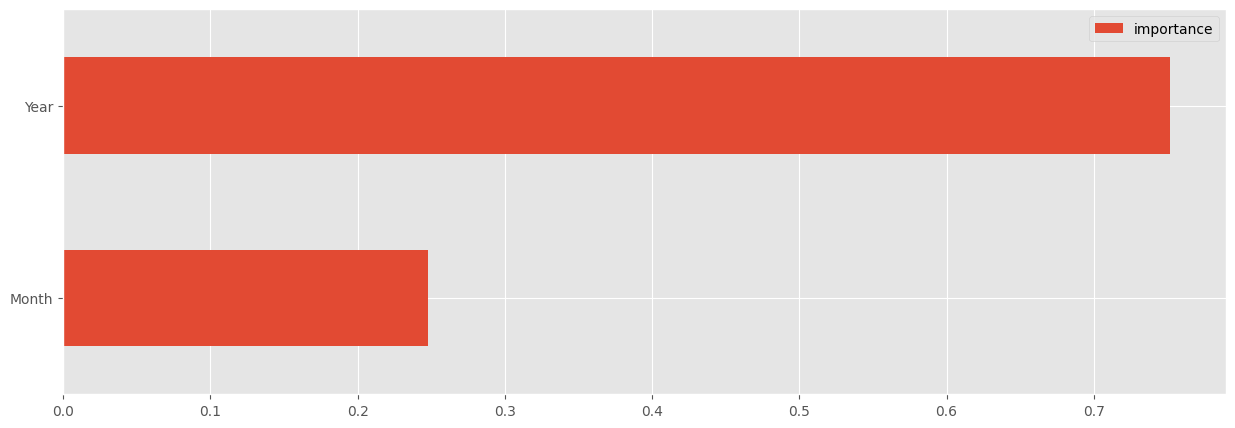

In [15]:
fi = pd.DataFrame(data = reg.feature_importances_,
                index = reg.feature_names_in_,
                columns = ["importance"])


fi.sort_values(by = "importance").plot(kind = "barh")
plt.show()

## Forecast

In [16]:
test["prediction"] = reg.predict(X_test)
test.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_1912\3611538061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = reg.predict(X_test)


,Production,Year,Month,prediction
Date,,,,
1975-01-01,834,1975,1,828.000488
1975-02-01,782,1975,2,777.995850
1975-03-01,892,1975,3,889.000610
1975-04-01,903,1975,4,902.007385
1975-05-01,966,1975,5,968.991699


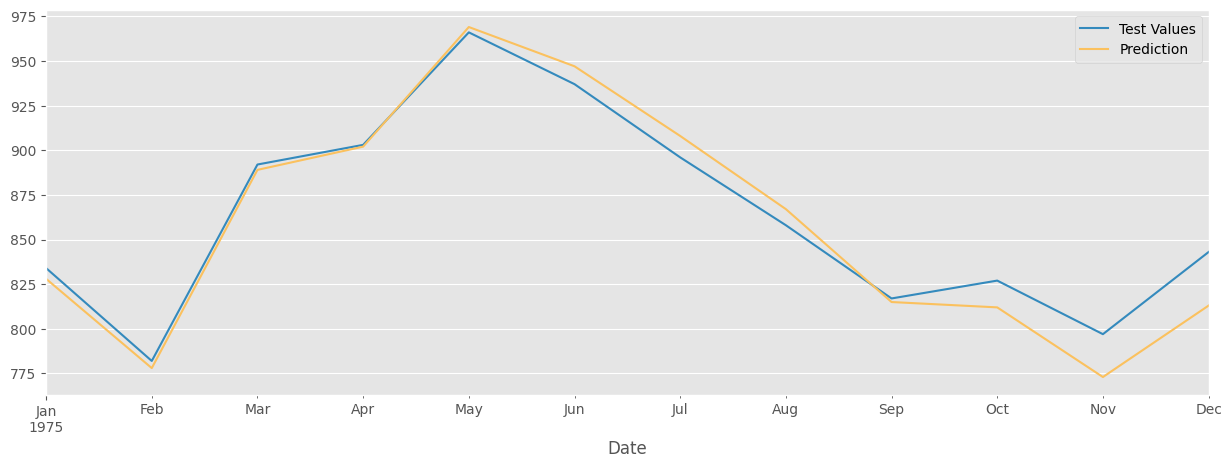

In [17]:
fig, ax = plt.subplots()

test["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test["prediction"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [18]:
# RMSE

root_mean_sq_error_1 = root_mean_squared_error(test["Production"], test["prediction"])  
root_mean_sq_error_1

13.231994052260703

In [19]:
def date_values(df, per):
    
    c = round(len(df) * per)
    train = df[:c]
    test = df[c:]

    Features = ["Year", "Month"]
    Target = "Production"

    X_train = train[Features]
    y_train = train[Target]

    X_test = test[Features]
    y_test = test[Target]

    reg = xgb.XGBRegressor(n_estimators = 1000,
                        early_stopping_round = 50,
                        learning_rate = 0.1)

    reg.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)], verbose = None)
    
    test["prediction"] = reg.predict(X_test)

    root_mean_sq_error_1 = root_mean_squared_error(test["Production"], test["prediction"])

    return  root_mean_sq_error_1

In [20]:
date_list = np.arange(0.1, 1.0, 0.1)

rsme_dict = {}


for i in date_list:

    rsme_dict[i] = date_values(df, i)

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping_round" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acast\AppData\Local\Temp\ipykernel_1912\644366270.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = reg.predict(X_test)
c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learn

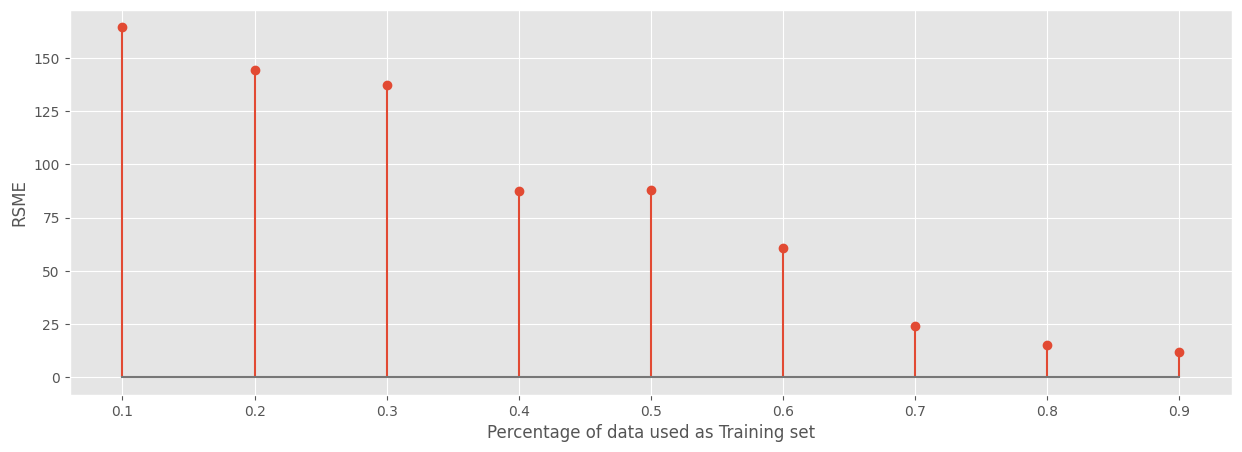

In [21]:
plt.stem(pd.DataFrame.from_dict(data =  rsme_dict, orient = "index").reset_index()["index"], pd.DataFrame.from_dict(data =  rsme_dict, orient = "index").reset_index()[0])

plt.ylabel("RSME")
plt.xlabel("Percentage of data used as Training set")
plt.show()

# **LSTM**

In [22]:
df_lstm = df[["Production"]]

df_lstm.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [23]:
train = df_lstm.iloc[:156]
test = df_lstm.iloc[156:]

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [25]:
scaler.fit(df_lstm)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [29]:
model = Sequential()
model.add(LSTM(100, activation = "relu", input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mse")

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.fit(generator, epochs = 50)

Epoch 1/50
 35/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1082

c:\Users\acast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0610
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048


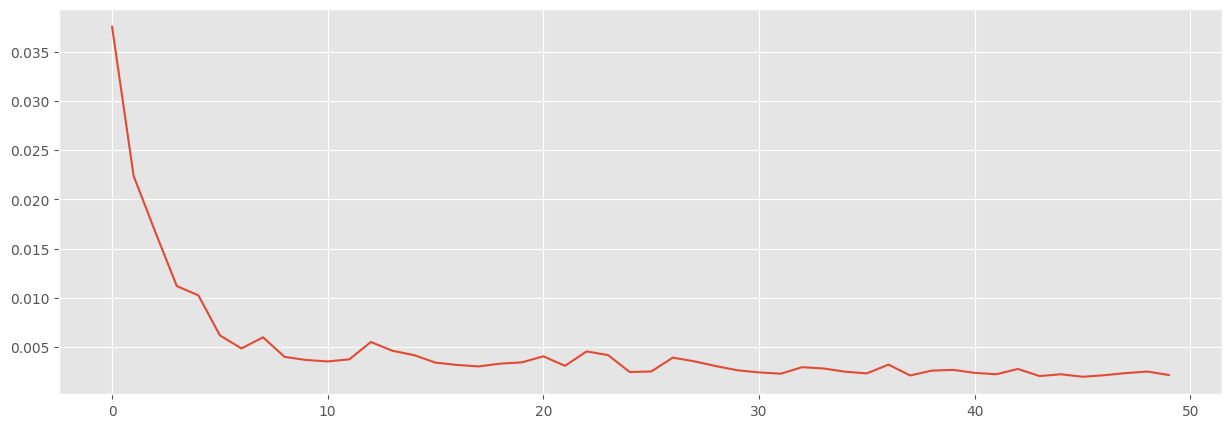

In [32]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [33]:
last_train_batch = scaled_train[-12:]

In [34]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [35]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


array([[0.6469316]], dtype=float32)

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]

    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test["prediction"] = true_predictions
test.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_1912\1189189730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = true_predictions


,Production,prediction
Date,,
1975-01-01,834,822.123541
1975-02-01,782,808.959295
1975-03-01,892,880.237177
1975-04-01,903,906.175659
1975-05-01,966,947.526871


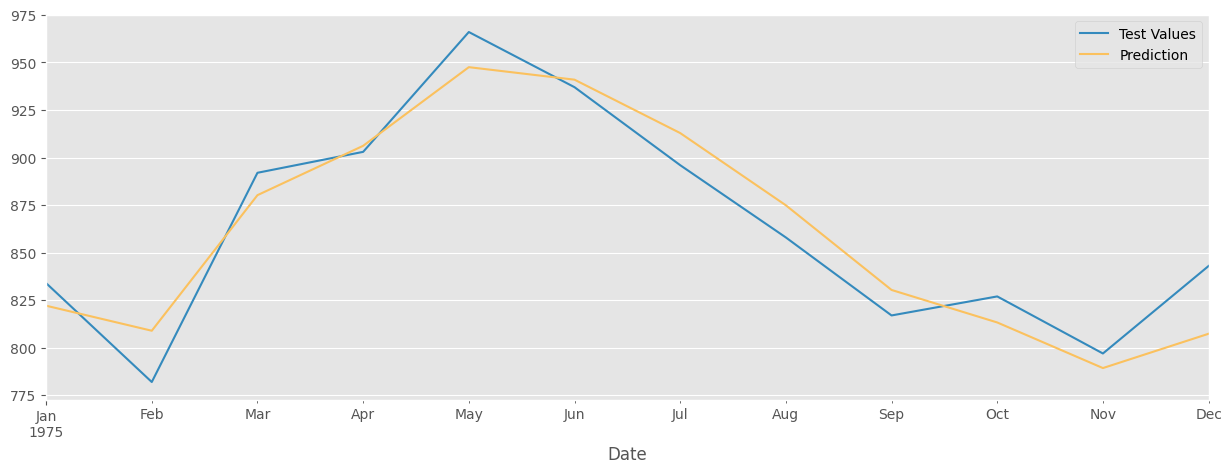

In [39]:
fig, ax = plt.subplots()

test["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test["prediction"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [40]:
# RMSE

root_mean_sq_error_2 = root_mean_squared_error(test["Production"], test["prediction"])  
root_mean_sq_error_2

17.414328580882348

# **Darts**

In [41]:
from darts import TimeSeries
from darts.models  import RegressionModel
from sklearn.linear_model import LinearRegression

In [42]:
y = TimeSeries.from_series(df["Production"])
y

<TimeSeries (DataArray) (Date: 168, component: 1, sample: 1)> Size: 1kB
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1kB 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 8B 'Production'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [43]:
y_train = y[:156]

In [44]:
model = RegressionModel(lags = [-1, -2, -12],
                        model = LinearRegression())

model.fit(series = y_train)

RegressionModel(lags=[-1, -2, -12], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, model=LinearRegression(), multi_models=True, use_static_covariates=True)

In [59]:
y_predict = model.predict(n = 12, series = y_train)

y_predict.pd_series()

Date
1975-01-01    843.724713
1975-02-01    802.483075
1975-03-01    894.977913
1975-04-01    917.896941
1975-05-01    977.911394
1975-06-01    965.050613
1975-07-01    928.092449
1975-08-01    887.913186
1975-09-01    838.106323
1975-10-01    830.430218
1975-11-01    796.078554
1975-12-01    827.496227
Freq: MS, Name: Production, dtype: float64

In [60]:
test["prediction_dart"] = y_predict.pd_series()

test.head()

C:\Users\acast\AppData\Local\Temp\ipykernel_1912\1576241215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction_dart"] = y_predict.pd_series()


,Production,prediction,prediction_dart
Date,,,
1975-01-01,834,822.123541,843.724713
1975-02-01,782,808.959295,802.483075
1975-03-01,892,880.237177,894.977913
1975-04-01,903,906.175659,917.896941
1975-05-01,966,947.526871,977.911394


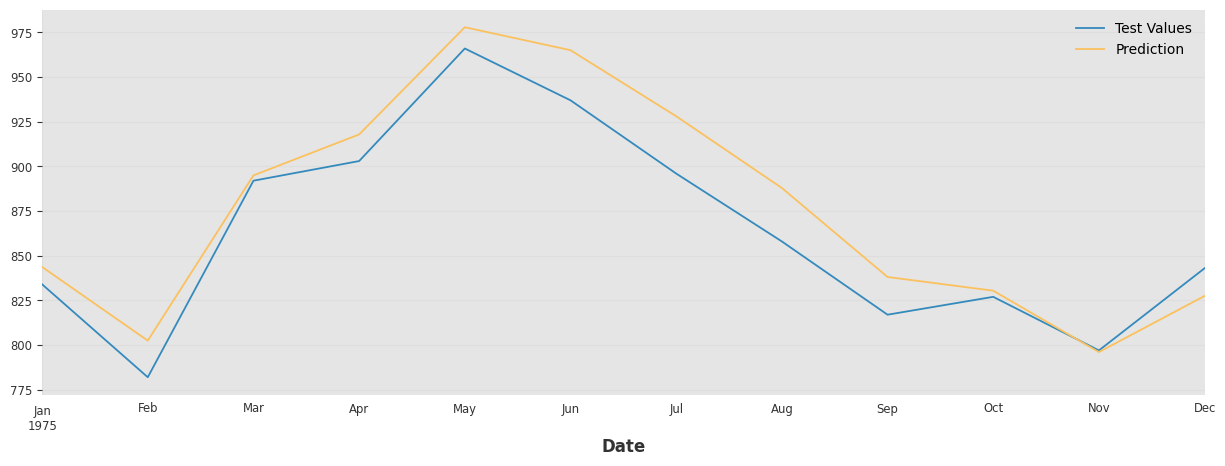

In [61]:
fig, ax = plt.subplots()

test["Production"].plot(ax = ax , label = "Test Values", color = color_pal[1])
test["prediction_dart"].plot(ax = ax, label = "Prediction", color = color_pal[4])
plt.legend(["Test Values", "Prediction"])
plt.show()

In [62]:
# RMSE

root_mean_sq_error_2 = root_mean_squared_error(test["Production"], test["prediction"])  
root_mean_sq_error_2

17.414328580882348

- https://www.youtube.com/watch?v=S8tpSG6Q2H0
- https://www.youtube.com/watch?v=vV12dGe_Fho&t=43s
- https://www.youtube.com/watch?v=9QtL7m3YS9I&t=1685s
